# Assignment 4: Markov Chain Monte Carlo

## Part 0: Introduction/Background

The following is some introductory terminology and 'get-started' exercises. **Part 0 is not a required part of the assignment, but may be useful to work through if you want to learn the basics.** It may also be familiar to you if you took ph20.

### 0.0 Theorems and terminology - Bayes' theorem

Imagine we have some data for a system that can be well described by a model, $M$. $M$ is characterized by some parameters $\mathbf{X} = \{ x_1, x_2, \ldots, x_M \}$. Suppose we have $N$ data, $\mathbf{D} = \{ d_1, d_2, \ldots, d_N \}$. Bayes' theorem states that

\begin{equation}
p(\mathbf{X} | \mathbf{D}, I) = \frac{p(\mathbf{D}|\mathbf{X}, I) p(\mathbf{X}|I)}{p(\mathbf{D}|I)}.
\end{equation}

In words, we may say: "The probability that the model parameters $\mathbf{X}$ are correct, given the data, is proportional to the probability of the data occuring, given the model parameters, multiplied by the probability of the model parameters, given our prior information about the system". Here, we ignore the denominator (which serves to correctly normalize our result as a probability).

$p(\mathbf{X}|I)$ is referred to as the **prior**, $p(\mathbf{X}|\mathbf{D}, I)$ is the **posterior**, and $p(\mathbf{D}|\mathbf{X}, I)$ is the **likelihood**.

### 0.1 Bayes' theorem example - Coin flipping

Suppose you flip a coin. $H$ is the probability of getting heads after flipping the coin once (for a normal, unbiased coin, this would be $0.5$). Suppose that we flip the coin $n$ times, and that $h$ heads occur. $h$ heads occur with probability $H^h$, and $n-h$ tails occur with probability $(1-H)^{n-h}$. We also need to account for all of the different orderings in which we could've gotten heads and tails. Overall, then, our **likelihood** is given by

\begin{equation}
p(\mathbf{D} | H, I) = \frac{n!}{h!(n-h)!}H^h (1-H)^{n-h}.
\end{equation}

Now, we must choose a **prior**, which is the probability for $H$, given the information. As of now we do not have any information about the system - we haven't been given a chance to inspect our coin or our environment. So, we choose something very basic, the uniform distribution: $p(\mathbf{H}|I) = 1$. If we had inspected the coin and were reasonably certain that it was a fair, unbaised coin, we may have chosen something like a normal distribution peaked around $0.5$, to demonstrate our **belief** that $H=0.5$.

The idea now is to compute the posterior, which will take into account information both about the data, and also about our prior assumptions. After computing the posterior, we should have a good **parameter estimate** for $H$. 

Your task is to demonstrate this idea by completing the code below. The code generates some data - flipping a biased coin 100 times. **Your practice tasks are denoted by comments 1-5 in the code block below**.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import special

## Generate some coin flipping data

H_true = 0.6 ## this is the true value of H - assume that we are flipping a 'slightly biased' coin
n = 100      ## flip the coin 100 times
data = np.random.rand(n)
h = int(np.sum(np.ceil(data[np.where(data<=H_true)])))  ##counts number of heads

## apply bayes' theorem to estimate H
prior = 1
dH = 0.01
eps = 1e-6 

## 1: A list of potential values for H
# H_vals = 

# 2: loop through the proposed values of H and compute the posterior
posterior = []
for H in H_vals:
    # 3: code in the likelihood described above (hint: scipy!)
    # likelihood =

    # 4: compute the posterior and add to list
       
# 5: Plot the resulting posterior distribution and include a vertical line to 
#    show the true value of H

### 0.2 Background - Monte Carlo methods

Bayesian parameter estimation does not scale well when we have lots of parameters in our system. Imagine we had a problem with two parameters to tune, $A$ and $B$. We could form a grid of potential values for $A$ and $B$, and compute the posterior over the grid. However, as the number of parameters increases, this method (very quickly) becomes unrealistic, as there are far too many points to sample over.

**An example - estimating pi**

Monte Carlo methods are methods which use random sampling to obtain numerical results. Let's demonstrate the idea by using Monte Carlo to estimate the value of $\pi$. Consider a quarter circle which is incribed in the unit square. The area of the square is $1$, and the area of the quarter circle is $\frac{\pi r^2}{4} = \frac{\pi}{4}$. This means that the ratio of the square's area to the quarter circle's area is $\pi/4$. Imagine throwing a bunch of darts at the square (uniformly scattering some points over the square). If the distance from the origin to a specific point is less than $1$, the point must be inside the quarter circle. We would expect that the ratio of the number of points inside the circle to the total number of points would be approximately $\pi/4$. Let's check try this out in the code below.


In [1]:
import numpy as np
n = 1000
in_circ = 0
for _ in range(n):
    pos = np.random.rand(2)
    dist = np.sqrt(pos[0]**2 + pos[1]**2)
    if dist < 1:
        in_circ += 1
pi = 4*in_circ/n
pi

3.208

### 0.3 Markov Chain Monte Carlo - the idea + some definitions

See numerical recipes section 15.8 if you are interested in a more detailed introduction.

MCMC is a random sampling method: we wish to visit a point $x$ in our sampling space according to some distribution $\pi(x)$, which for us will be the unknown posterior distribution. MCMC automatically samples the points where $\pi$ is large preferentially. There are two insights that make MCMC work well.

1) $\pi$ is sampled via a **Markov Chain**. This means that instead of each point being sampled independently, each point depends directly on the previously sampled point. This 'memory' only goes back one step in time. We represent this by a transition probability $p(x_n | x_{n-1})$.
2) The detailed balance condition: $$ \pi(x_1) p(x_2 | x_1) = \pi(x_2) p (x_1| x_2).$$

These two insights ensure that MCMC has the **ergodic property** eventually, we will visit all points in the sample space with probability proportional to $\pi$.

**The Metropolis-Hastings algorithm**

This is an example of an MCMC algorithm. The steps are, roughly, as follows:

1) Pick a proposed transition distribution q(x_2|x_1).
2) From your starting point, $x_1$, generate a candidate step $x_{2c}$.
3) Compute an acceptance probability $$\alpha(x_1, x_{2c}) = \texttt{min}\left(1, \frac{\pi(x_{2c}) q(x_1|x_2))}{\pi(x_1)q(x_{2c}|x_1)}\right).$$
4) Either accept or reject the next step.

### 0.4 MCMC in python - the coin flipping example again

There are a few packages available for doing MCMC in python. In this practice exercise, you will use the emcee package to redo the coin-tossing example at the beginning of this document. In the blocks below, you are provided with a skeleton code and commented instructions. When you are finished writing the code, try changing a few of the parameters such as the number of walkers, or the number of steps that the MCMC sampler runs for. Comment on how changing these parameters effects the outcome of your results.

In [4]:
import numpy as np
import emcee
from numpy.random import randn, rand
import matplotlib.pyplot as plt
#import matplotlib as mpl
import matplotlib.gridspec as gridspec
import corner

# to check code execution times
from timeit import default_timer as timer

In [9]:
## define the probability distributions. NOTE: probabilities can be ZERO and the log of zero is infinite. make sure you include something in your code to catch
## the infinities. Returning -infinity is allowed by emcee.

# returns the log of the chosen prior
def log_prior(H):
    if H < 0 or H > 1:
        return -np.inf
    return np.log(H)


# returns the log the likelihood
def log_likelihood(H, h, n):
    return h*log_prior(H) + (n-h)*log_prior(1-H)


# returns the log posterior
def log_posterior(H, h, n):
    return log_prior(H) + log_likelihood(H, h, n)

In [8]:
## set up the parameters for your simulation. Input reasonable values

ndim = 1
n_walkers = 4 # should be sufficient bc the problem is simple

In [5]:
	
## generating the "observed data" - nothing to do here, but you will use the results of this block!

n = 500
H_true = 0.5
data = np.random.rand(n)
h = int(np.sum(np.ceil(data[np.where(data>=H_true)])))

In [10]:
## running the MCMC simulation. refer to the emcee quickstart guide for help in filling in this section.

# define p0, the random starting points for each of the walkers
# instantiate your sampler
# run a few "burn in steps"
# run the MCMC sampler.

np.random.seed(42)
p0 = np.random.rand(n_walkers, ndim)

sampler = emcee.EnsembleSampler(n_walkers, ndim, log_posterior, args=[h, n])

In [11]:
state = sampler.run_mcmc(p0, 100)
sampler.reset()

In [12]:
sampler.run_mcmc(state, 100)

State([[0.49833467]
 [0.53277201]
 [0.4888849 ]
 [0.49946665]], log_prob=[-347.31281508 -347.4919127  -347.67960061 -347.28088957], blobs=None, random_state=('MT19937', array([3270816789, 3896374300, 1702423626, 2661908389, 2711745975,
       1901554457, 1434175292, 3283496191, 1669209735,  589448943,
       3693323108, 2801583663, 1764875020, 2386631866, 3011873906,
         45670343,  239047561, 2235000530, 3674573063, 1366798076,
       2027433937, 1292647576, 4124507412,  925815027, 2724498389,
       3719662536,  780547121, 3870505154,  257852989, 2502585477,
        836939130, 3810031279, 3967082256, 2074933539, 1287675565,
       1532049189,  260806149, 1556813822, 1344738357,  306528171,
       1948523893,  343747994, 1553310063,  476721323, 3837030737,
       2506156988,  373416150,  192270519, 3512310740, 3135333531,
        143613656,   88926937, 3694962368, 2831246471, 2875566479,
       1972802670, 2299977057, 1152449505,  821477784, 3016961709,
       1511753786, 21010450

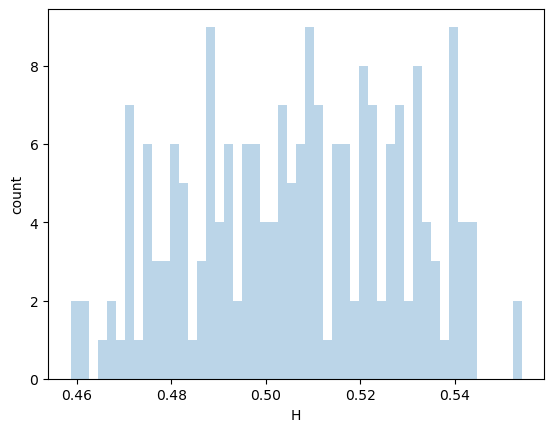

In [17]:
import matplotlib.pyplot as plt

samples = sampler.chain[:, 50:, :].reshape((-1, ndim))
plt.hist(samples, bins=50, histtype="stepfilled", alpha=0.3)
plt.xlabel("H")
plt.ylabel("count")
plt.show()

In [ ]:
# Final step: make a descriptive plot of the resulting posterior. 

## Part 1: Galaxy Rotation Curves

**This part of the assignment is compulsory.**

Galaxy rotation curves plot the orbital speeds of objects in the galaxy versus their radial distance from the center of the galaxy. The experimentally observed curves differ greatly from those that are generated by applying Newtonian mechanics to the known matter in the galaxy - this discrepency can be resolved by involving dark matter.

In this assignment, you will set up a model for a galaxy rotation curve involving dark matter and use MCMC to fit the model parameters. You will use the emcee package to do this - if you are not familiar with this, the quickstart page in the docs is very informative. Part 0.4 can be used as a warm-up example if you need some more help.

### 1.0 Setting up a model

The total velocity is calculated as a combination of the visible matter velocity and the dark matter velocity.

Write a function to compute the velocity function for dark matter. We will model this using the Navarro-Frenk-White (NFW) profile. First, solve for velocity by equating the centripital force to Newtonian gravitational force. Then, eliminate the mass using information from the NFW wikipedia page: https://en.wikipedia.org/wiki/Navarro–Frenk–White_profile

In [18]:
# imports

import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner

In [20]:
# Define the velocity function for visible matter
def visible_matter_velocity(r, v_bulge_max, r_bulge):
    """
    Calculate the rotation curve velocity due to visible matter, modeled with a simple bulge component.
    """
    v_bulge = v_bulge_max * np.tanh(r / r_bulge)
    return v_bulge

# Define the velocity function for dark matter (NFW profile)
def nfw_velocity(r, rho_0, r_s):
    """
    Calculate the rotation curve velocity for the NFW dark matter profile.
    """
    x = r / r_s
    mass_enclosed = 4 * np.pi * rho_0 * r_s**3 * (np.log(1 + x) - x / (1 + x))
    r_safe = np.where(r == 0, 1e-8, r)
    v_nfw = np.sqrt(mass_enclosed / r_safe) #G = 1
    return v_nfw


# Total velocity combining both contributions
def total_velocity(r, v_bulge_max, r_bulge, rho_0, r_s):
    
    """
    Calculate the total rotation curve velocity, combining contributions from visible and dark matter.
    """
    v_visible = visible_matter_velocity(r, v_bulge_max, r_bulge)
    v_nfw = nfw_velocity(r, rho_0, r_s)
    return np.sqrt(v_visible**2 + v_nfw**2)

rs = np.arange(0, 30, 0.1)
vs = visible_matter_velocity(rs,1,1)

### 1.1 Simulating some data

We are going to attempt to fit our theoretical model (defined above) to some noisy simulated data. In this step, write a function that simulates this data by computing the total velocity and adding random noise to the data.

In [21]:
# Function to simulate galaxy rotation curve data with noise
def simulate_data(r, v_bulge_max=150, r_bulge=2, rho_0=0.1, r_s=10, noise_level=5):
    """
    Simulate rotation curve data for a galaxy with contributions from both visible matter (bulge/disk) and dark matter (NFW profile).
    """
    v_total = total_velocity(r, v_bulge_max, r_bulge, rho_0, r_s)
    noise = noise_level * np.random.randn(len(r))
    return v_total + noise

### 1.2 MCMC setup

Next, write three functions that return the (log) prior, likelihood, and posterior. The prior should be used to reasonably constrain the values of the parameters. The likelihood is our model, given by total velocity. Constrain the parameters to obey $0 < v_{bm} < 300$, $0<r_b<10$, $0<\rho_0<1$, $0<r_s<50$.

In [22]:
# Log-prior function
def log_prior(theta):
    """
    Define the prior probabilities for the model parameters.
    """
    v_bm, r_b, rho_0, r_s = theta
    if 0 < v_bm < 300 and 0 < r_b < 10 and 0 < rho_0 < 1 and 0 < r_s < 50:
        return 0.0  # prior within the bounds
    return -np.inf
    

# Log-likelihood function
def log_likelihood(theta, r, v_observed):
    """
    Calculate the log likelihood of the observed data given the model parameters.
    """
    v_bm, r_b, rho_0, r_s = theta
    v_model = total_velocity(r, v_bm, r_b, rho_0, r_s)
    log_likelihood = -0.5 * np.sum((v_observed - v_model)**2)
    return log_likelihood


# Total log-probability function
def log_probability(theta, r, v_observed):
    """
    Calculate the total log probability (prior + likelihood) of the model given the data.
    """
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, r, v_observed)

### 1.3 MCMC run and result

Now, run the MCMC simulation and plot the resulting best-fit model along with the data points.

Create a corner plot of the results. How do you interpret this corner plot?

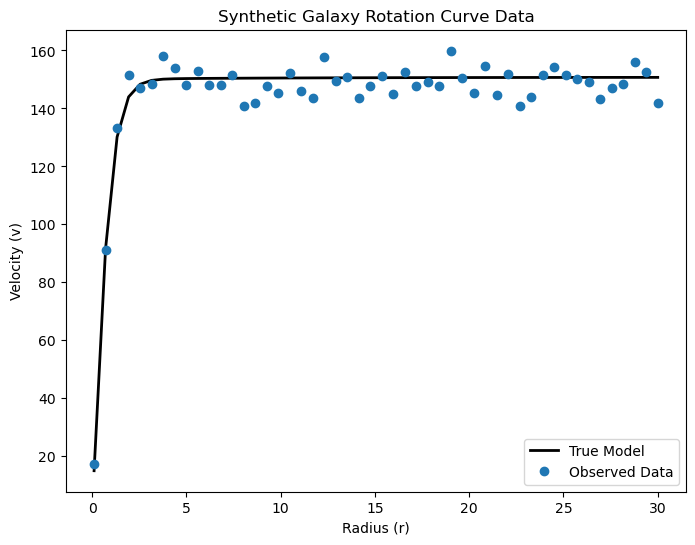

In [23]:
np.random.seed(42)
true_params = [150, 1, 0.2, 20]
r = np.linspace(0.1, 30, 50)
v_true = total_velocity(r, *true_params)
v_observed = simulate_data(r, *true_params)

# Plot the synthetic data
plt.figure(figsize=(8,6))
plt.errorbar(r, v_observed, fmt='o', label='Observed Data')
plt.plot(r, v_true, label='True Model', color='k', lw=2)
plt.xlabel("Radius (r)")
plt.ylabel("Velocity (v)")
plt.legend()
plt.title("Synthetic Galaxy Rotation Curve Data")
plt.show()

In [26]:
ndim = 4
nwalkers = 32

p0 = np.random.rand(nwalkers, ndim) * np.array([300, 10, 1, 50])

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(r, v_observed))

nsteps = 1000
# burnin
state = sampler.run_mcmc(p0, nsteps, progress=True)

sampler.reset()

# production
sampler.run_mcmc(state, nsteps, progress=True)
samples = sampler.get_chain(flat=True)
best_fit = np.median(samples, axis=0)
print("Best-fit parameters (median of posterior):")
print("v_bm =", best_fit[0])
print("r_b  =", best_fit[1])
print("rho_0 =", best_fit[2])
print("r_s  =", best_fit[3])

100%|██████████| 1000/1000 [00:00<00:00, 1707.70it/s]

Best-fit parameters (median of posterior):
v_bm = 149.10593429153482
r_b  = 0.9470212384784226
rho_0 = 0.3202687910592017
r_s  = 3.933174399490227


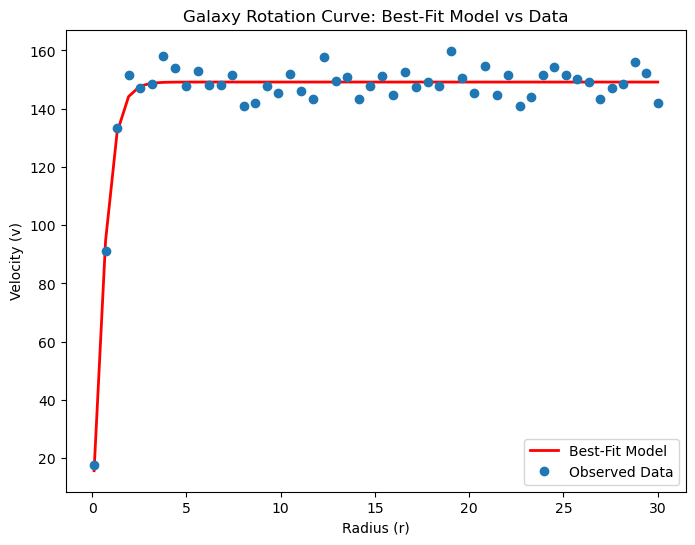

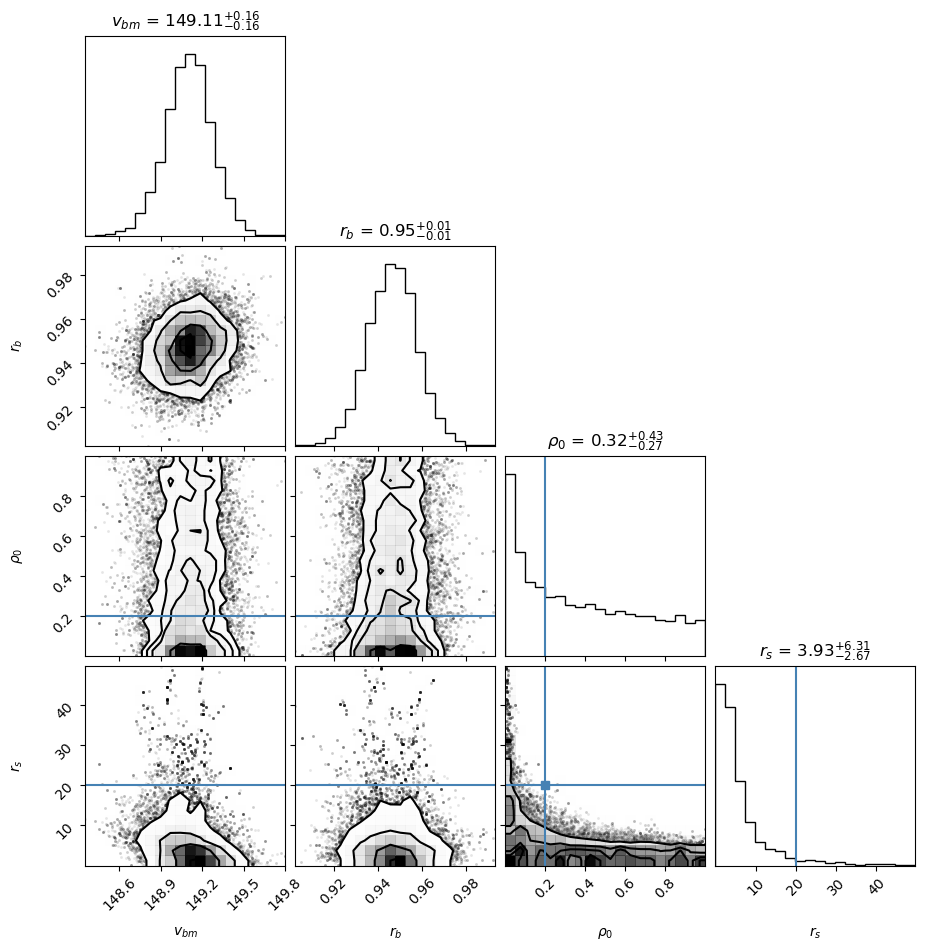

In [ ]:
# Plot best-fit model vs data
v_best = total_velocity(r, *best_fit)
plt.figure(figsize=(8,6))
plt.errorbar(r, v_observed, fmt='o', label='Observed Data')
plt.plot(r, v_best, label='Best-Fit Model', color='r', lw=2)
plt.xlabel("Radius (r)")
plt.ylabel("Velocity (v)")
plt.title("Galaxy Rotation Curve: Best-Fit Model vs Data")
plt.legend()
plt.show()

# Corner Plot
labels = [r"$v_{bm}$", r"$r_b$", r"$\rho_0$", r"$r_s$"]
fig_corner = corner.corner(samples, labels=labels, truths=true_params, 
                           show_titles=True, title_fmt=".2f", title_kwargs={"fontsize": 12})
plt.show()

"The corner plot shows all the one and two dimensional projections of the posterior probability distributions of your parameters.".

Looking into the marginal posterior distribution, we note that $v_{bm}, r_b$ is Gaussian but $\rho_0$ and $r_s$ are like truncated Gaussian (only the right wing), very right skewed.

Here $v_{bm}$ and $r_b$ look like an independent joint bivariate Gaussian. For $\rho_0$, it seems that same $v_{bm}$ / $r_b$ and different $\rho_0$ will lead to the same probability, so $v_{bm}$ / $r_b$ dominates the posterior.
For $r_s$, its corner plots with $v_{bm}$ and $r_b$ look like half of an independent joint bivariate Gaussian, but its plot with $\rho_0$ indicates that they are strongly correlated. 